## Dacon  14 회 금융문자 분석 모델링 경진대회
## 팀명: DA501
## 2020년 1월 20일 (제출날짜)

# 모델링 코드 작성방법

A 코드 관련

1) 입상자는 코드 제출 필수. 제출 코드는 예측 결과를 리더보드 점수로 복원할 수 있어야 함

2) 코드 제출시 확장자가 R user는 R or .rmd. Python user는 .py or .ipynb

3) 코드에 ‘/data’ 데이터 입/출력 경로 포함 제출 or R의 경우 setwd(" "), python의 경우 os.chdir을 활용하여 경로 통일

4) 전체 프로세스를 일목요연하게 정리하여 주석을 포함하여 하나의 파일로 제출

5) 모든 코드는 오류 없이 실행되어야 함(라이브러리 로딩 코드 포함되어야 함).

6) 코드와 주석의 인코딩은 모두 UTF-8을 사용하여야 함

 
B 외부 데이터 관련

1) 외부 공공 데이터 (날씨 정보 등) 사용이 가능하나, 코드 제출 시 함께 제출

2) 공공 데이터 외의 외부 데이터는 법적인 제약이 없는 경우에만 사용 가능

3) 외부 데이터를 크롤링할 경우, 크롤링 코드도 함께 제출

## 1. 라이브러리 및 데이터
## Library & Data

In [15]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from konlpy.tag import Komoran
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential
import os
from keras.models import load_model
import pickle

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.chdir('../0_Data')

train=pd.read_csv("train.csv")
test=pd.read_csv("public_test.csv")

## Crawling Code(크롤링 진행 시 기입)

In [ ]:
# 없음

## 2. 데이터 전처리
## Data Cleansing & Pre-Processing

* train data 전처리

In [4]:
# Komoran을 통해 형태소 분석 후, 명사만 추출하여  train_noun_result 리스트에 저장함
komoran = Komoran()

docs = train.text
train_noun_result = list(map(komoran.nouns, docs))

* test data 전처리

In [5]:
# Komoran을 통해 형태소 분석 후, 명사만 추출하여 test_noun_result 리스트에 저장함
komoran = Komoran()

docs = test.text
test_noun_result = list(map(komoran.nouns, docs))

* 데이터 토큰화 이전, 필요한 전처리 과정 수행

In [6]:
# test data에 smishing 컬럼을 추가
test['smishing'] = np.nan

In [7]:
# train data, test data 각각에 형태소 분석 후 명사만 추출한 결과를 result 컬럼에 추가
train['result'] = train_noun_result
test['result'] = test_noun_result

In [8]:
# train data, test data를 concat
temp = pd.concat([train, test], axis=0)

In [9]:
X_data = temp['result']
y_data = temp['smishing']
print('문자의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

문자의 개수: 297571
레이블의 개수: 297571


* 토큰화 과정

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data) #297571개의 row를 가진 X_data의 각 행에 토큰화 수행
sequences = tokenizer.texts_to_sequences(X_data) # 각 명사 단어를 숫자값, 인덱스로 변환하여 저장

In [11]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index)+1
print('명사 단어 집합의 크기: {}'.format((vocab_size))) 

명사 단어 집합의 크기: 21985


In [16]:
# 토큰화 된 벡터에 배정 될 명사 단어 집합 저장하기
os.chdir('../1_Model')

with open('noun_sets.pickle', 'wb') as f:
    pickle.dump(word_to_index, f, pickle.HIGHEST_PROTOCOL)

## 3. 탐색적 자료분석
## Exploratory Data Analysis


* train data의 레이블 분포 확인 ( 1: 스미싱 문자 , 0: 일반 문자)

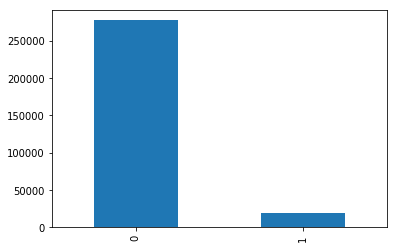

In [17]:
train['smishing'].value_counts().plot(kind='bar')

* 토큰화 후, 문자의 최대 길이 및 평균 길이 확인

문자의 최대 길이 : 499
문자의 평균 길이 : 34.044074


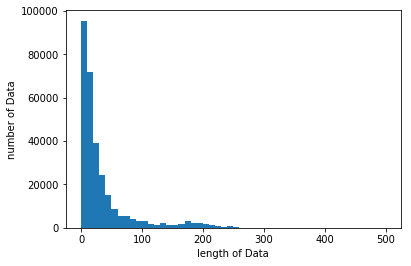

In [18]:
X_data = sequences
print('문자의 최대 길이 : %d' % max(len(l) for l in X_data))
print('문자의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

* train data에서 전체 문자(스미싱 문자+일반 문자)의 월별 분포 확인

Text(0.5, 1.0, '# of entire messages each month')

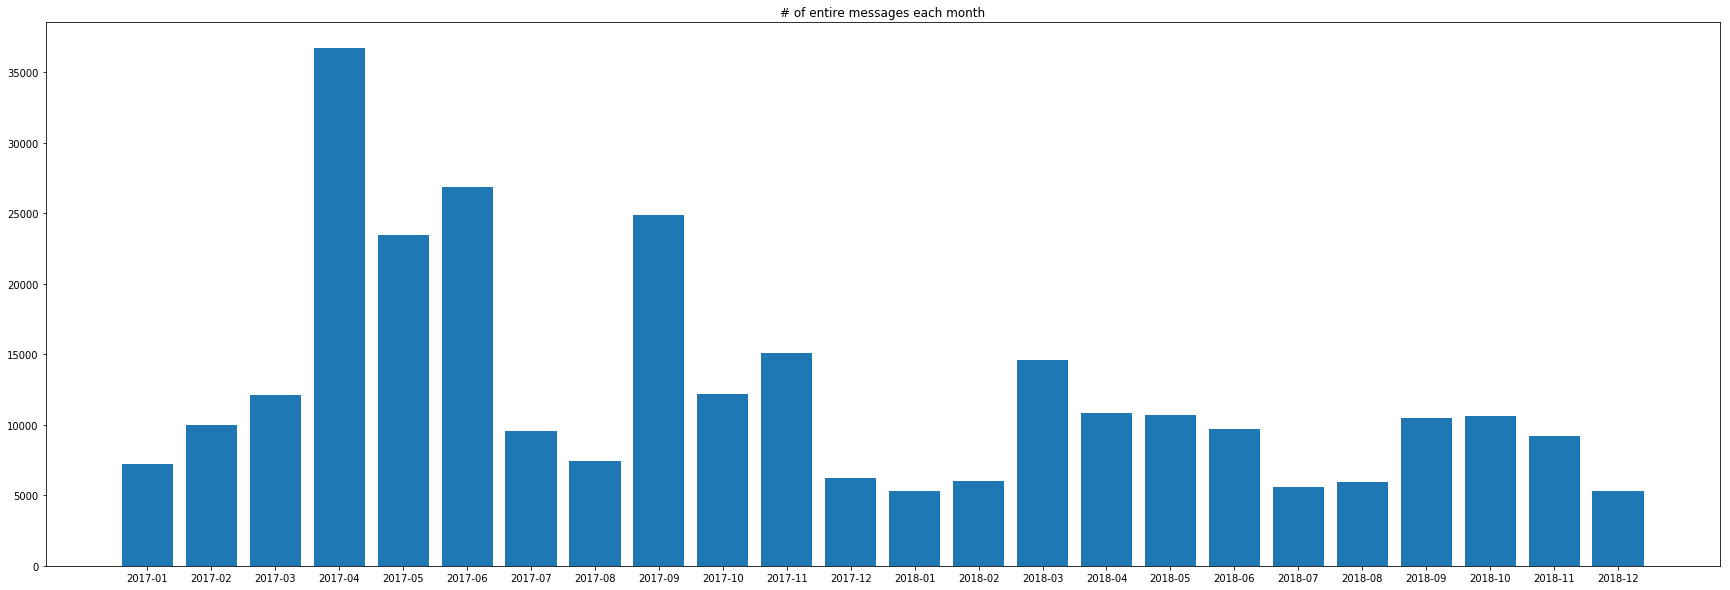

In [19]:
monthly_text = train.pivot_table(index='year_month', values='id', aggfunc='count')
plt.figure(figsize=(30, 10))
plt.bar(monthly_text.index, monthly_text['id']) 
plt.title('# of entire messages each month')

* train data에서 전체 문자(스미싱 문자+일반 문자)의 월별 분포 확인

Text(0.5, 1.0, '# of smishing each month')

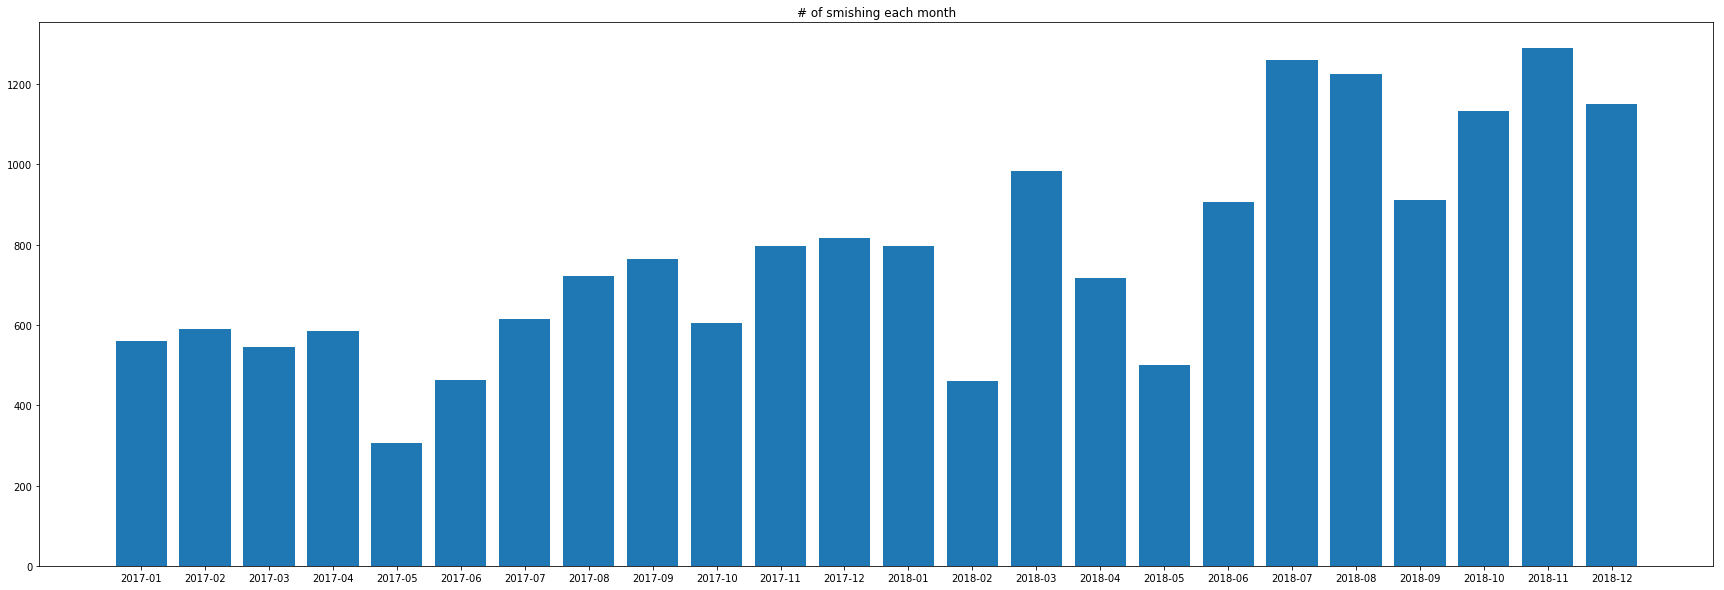

In [20]:
monthly_smish = train[train['smishing']==1].pivot_table(index='year_month', values='id', aggfunc='count')
plt.figure(figsize=(30, 10))
plt.bar(monthly_smish.index, monthly_smish['id']) 
plt.title('# of smishing each month')

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling

In [21]:
# 위의 EDA에서 문자의 최대 길이가 499임을 확인했으므로, 전체 토큰화된 데이터의 길이는 499로 맞춤
max_len = max(len(l) for l in X_data) #499
data = pad_sequences(X_data, maxlen=max_len)
print("data shape: ", data.shape)

data shape:  (297571, 499)


In [22]:
# train, test data의 shape 확인
print("train data shape 확인: " , train.shape)
print("test data shape 확인: " , test.shape)

train data shape 확인:  (295945, 5)
test data shape 확인:  (1626, 5)


* 학습 진행 이전, X_train, y_train, X_test, y_test 로 데이터 분리  
  (data는 train data와 test data를 세로 방향으로 concat한 것으로, train data의 shape 확인 후 다음과 같이 데이터 슬라이싱) 

In [23]:
X_train = data[:295945] 
y_train = np.array(y_data[:295945]) 
X_test = data[295945:]
y_test = np.array(y_data[295945:])

* 최종 모델은 model1과 model2 두개의 RNN 모델의 앙상블 모델이므로, 각 모델의 구축 과정을 다음과 같이 진행함

#### 1) model1 구축 과정

In [24]:
model1 = Sequential()
model1.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model1.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.


#### 2) model2 구축 과정

In [25]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model2.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation

#### 1) model1 에 대한 과정 진행

In [26]:
# model1 학습 및 검증
model1.fit(X_train, y_train, epochs=2, batch_size=60, validation_split=0.2, verbose=True)

Train on 236756 samples, validate on 59189 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
236756/236756 [==============================] - 463s 2ms/sample - loss: 0.0080 - acc: 0.9982 - val_loss: 0.0163 - val_acc: 0.9954
Epoch 2/2
236756/236756 [==============================] - 470s 2ms/sample - loss: 0.0020 - acc: 0.9997 - val_loss: 0.0138 - val_acc: 0.9976


In [27]:
# model1 저장
os.chdir('../1_Model')
model1.save('model1.h5')

In [28]:
# model1의 predict 값을 test data의 smishing1 컬럼에 저장
test['smishing1'] = model1.predict(X_test)

#### 2) model2 에 대한 과정 진행

In [29]:
# model2 학습 및 검증
model2.fit(X_train, y_train, epochs=2, batch_size=60, validation_split=0.2, verbose=True)

Train on 236756 samples, validate on 59189 samples
Epoch 1/2
236756/236756 [==============================] - 464s 2ms/sample - loss: 0.0095 - acc: 0.9981 - val_loss: 0.0072 - val_acc: 0.9985
Epoch 2/2
236756/236756 [==============================] - 499s 2ms/sample - loss: 0.0019 - acc: 0.9997 - val_loss: 0.0202 - val_acc: 0.9961


In [30]:
# model2 저장
os.chdir('../1_Model')
model2.save('model2.h5')

In [31]:
# model2의 predict 값을 test data의 smishing2 컬럼에 저장
test['smishing2'] = model2.predict(X_test)

#### 3) model1과 model2의 6:4 weighted mean 앙상블로 최종 예측값 출력

In [32]:
test['smishing'] = (test['smishing1']*6 + test['smishing2']*4)/10

## 6. 결과 및 결언
## Conclusion & Discussion

In [ ]:
# 생략